Enfoque del dataset de noticias falsas basado en RNN con BiLSTM

In [9]:
### IMPORTS ###
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import tensorflow as tf 
tf.random.set_seed(55) # para asegurar experimentos son reproducibles
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import accuracy_score, classification_report 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import gensim.downloader as api

# Cargar Dataset

In [10]:
### ROOT DATA ###
import pathlib
PATH = str(pathlib.Path().resolve()).removesuffix('\FakeNews') + "\Datasets\Fakeddit"

In [11]:
### CONJUNTOS DE ENTRENAMIENTO, VALIDACIÓN Y TEST ###
df = pd.read_csv(PATH + "\\multimodal_train.tsv",  sep='\t', on_bad_lines='skip')
df = df[['clean_title', '6_way_label']]
df = df.rename(columns={"clean_title": "Text", "6_way_label": "Label"})
df.fillna(" ", inplace=True)

X_train = df['Text']
y_train = df['Label']

X_train, X_aux, y_train, y_aux = train_test_split(X_train, y_train, test_size=0.95, random_state=55, stratify=y_train)

df = pd.read_csv(PATH + "\\multimodal_validate.tsv",  sep='\t', on_bad_lines='skip')
df = df[['clean_title', '6_way_label']]
df = df.rename(columns={"clean_title": "Text", "6_way_label": "Label"})
df.fillna(" ", inplace=True)

X_val = df['Text']
y_val = df['Label']

X_val, X_aux, y_val, y_aux = train_test_split(X_val, y_val, test_size=0.95, random_state=55, stratify=y_val)

df = pd.read_csv(PATH + "\\multimodal_test_public.tsv",  sep='\t', on_bad_lines='skip')
df = df[['clean_title', '6_way_label']]
df = df.rename(columns={"clean_title": "Text", "6_way_label": "Label"})
df.fillna(" ", inplace=True)

X_test = df['Text']
y_test = df['Label']

X_test, X_aux, y_test, y_aux = train_test_split(X_test, y_test, test_size=0.95, random_state=55, stratify=y_test)

print('Tamaño conjunto de Entrenamiento:', len(X_train))
print('Tamaño conjunto de Validación:', len(X_val))
print('Tamaño conjunto de Evaluación:', len(X_test))

Tamaño conjunto de Entrenamiento: 28200
Tamaño conjunto de Validación: 2967
Tamaño conjunto de Evaluación: 2965


# Label Encoding

In [12]:
### LABEL ENCODING ###
y_train = y_train.tolist()
y_val = y_val.tolist()
y_test = y_test.tolist()

LABELS = sorted(set(y_train))
NUM_LABELS = len(LABELS)

idx2label={}
label2idx={}
for index, label in enumerate(LABELS):
    label2idx.update([(label, index)])
    idx2label.update([(index, label)])

print('Labels:', label2idx)
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_train_cat = to_categorical(y_train)
y_val = le.fit_transform(y_val)
y_val_cat = to_categorical(y_val)
y_test = le.fit_transform(y_test)
y_test_cat = to_categorical(y_test)

Labels: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}


# Tokenización

In [13]:
tokenizer = Tokenizer(oov_token = True)
tokenizer.fit_on_texts(X_train)
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario = {}".format(NUM_WORDS))

MAX_LEN= 100 # longitud de la secuencia
encoded_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = MAX_LEN, padding='post')
encoded_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen = MAX_LEN, padding='post')
encoded_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = MAX_LEN, padding='post')

Tamaño del vocabulario = 25363


# Matriz de Embedding

In [14]:
#model_we = api.load("glove-wiki-gigaword-50")       #EMBED_SIZE = 50
model_we = api.load("word2vec-google-news-300")     #EMBED_SIZE = 300

EMBED_SIZE = 300

# creamos una matriz para los textos del conjunto de entrenamiento
embedding_matrix = np.zeros((NUM_WORDS, EMBED_SIZE))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = model_we[word]
        # word embedding para la palabra con índice i
        embedding_matrix[i] = embedding_vector
    except:
        #if word does not exist, we do not udpate the matrix
        pass

# **BiLSTM**

In [15]:
EMBEDDING_SIZE = EMBED_SIZE
DROPOUT = 0.4

model = Sequential()
# capa donde se crea la matriz de word embeddings
# Cada token está asociado con un entero (gracias a la tokenización)
# Cada entero está asociado a un vector de la matriz
# Las secuencias se representan con estos vectores
model.add(Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=MAX_LEN, weights=[embedding_matrix]))

model.add(Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.2)))
# Añadimos una capaz droput después de la capa bilstm 
model.add(Dropout(DROPOUT))

model.add(Bidirectional(LSTM(50, recurrent_dropout=0.2)))
model.add(Dropout(DROPOUT))

model.add(Dense(50, activation='relu'))
model.add(Dense(NUM_LABELS, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 300)          7608900   
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 200)         320800    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 100, 200)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 100)              100400    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 50)               

# Training

In [16]:
epochs = 10 # número de veces que pasamos sobre el conjunto de aprendizaje
batch_size = 16 

# training
history=model.fit(encoded_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_data=(encoded_val, y_val_cat), callbacks=[earlyStopping])


Epoch 1/10
1763/1763 [==============================] - 2474s 1s/step - loss: 0.9772 - accuracy: 0.6518 - val_loss: 0.8559 - val_accuracy: 0.6879
Epoch 2/10
1763/1763 [==============================] - 2187s 1s/step - loss: 0.6352 - accuracy: 0.7800 - val_loss: 0.8971 - val_accuracy: 0.6876
Epoch 3/10
1763/1763 [==============================] - 2238s 1s/step - loss: 0.3794 - accuracy: 0.8739 - val_loss: 1.0531 - val_accuracy: 0.6734
Epoch 4/10
1763/1763 [==============================] - 2261s 1s/step - loss: 0.2370 - accuracy: 0.9194 - val_loss: 1.3153 - val_accuracy: 0.6579


# Curvas de Aprendizaje

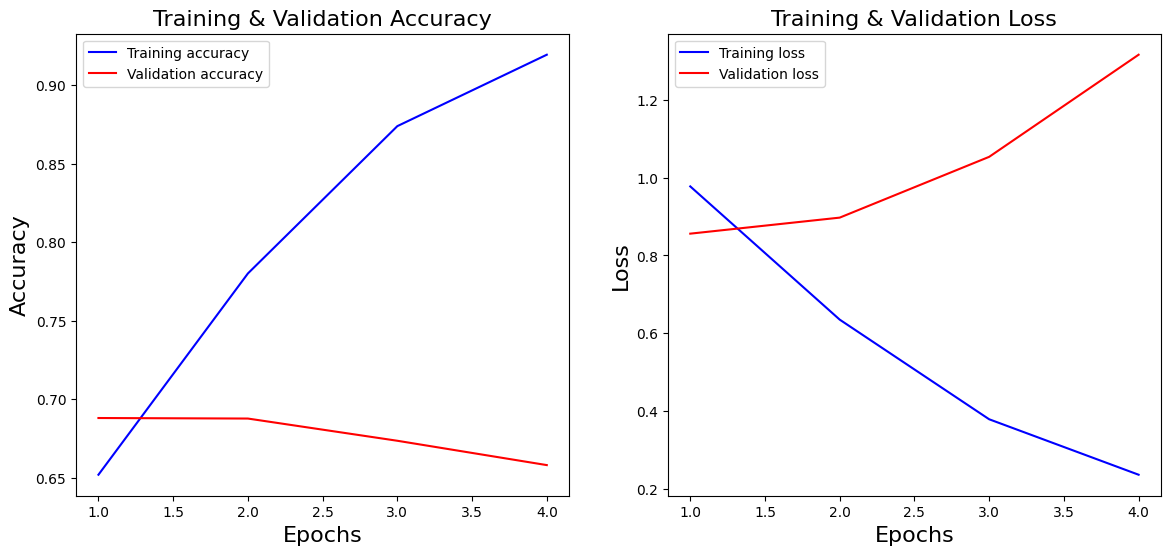

In [17]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'red', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'b', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'red', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

# Evaluación

In [18]:
loss, accuracy = model.evaluate(encoded_test, y_test_cat, batch_size=batch_size)

y_pred = np.argmax(model.predict(encoded_test), axis=1)
print('Accuracy:', accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred, target_names=['0', '1','2','3','4','5']))

93/93 [==============================] - 86s 874ms/step
Accuracy: 0.6596964586846543
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1175
           1       0.32      0.20      0.24       176
           2       0.49      0.56      0.52       565
           3       0.23      0.31      0.26        61
           4       0.76      0.77      0.76       873
           5       0.52      0.48      0.50       115

    accuracy                           0.66      2965
   macro avg       0.51      0.51      0.51      2965
weighted avg       0.66      0.66      0.66      2965



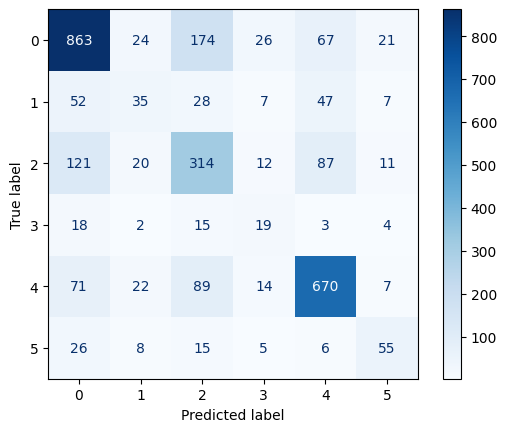

In [19]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1','2','3','4','5'])
disp.plot(cmap=plt.cm.Blues,values_format='g')